# BigARTM Python API.

BigARTM --- открытая библиотека для тематического моделирования текстовых коллекций, реализующая теорию Аддитивной регуляризации тематических моделей (ARTM). Основной сайт проекта http://bigartm.org/.

Здесь приводится пример использования пользовательского Python API библиотеки. Мы проведём демонстрационный эксперимент.

####Описание:
Построим две тематические модели коллекции текстовых документов, ARTM и PLSA, сравненим качество полученных моделей.

####Функционалы качества:
Важным функционалом является перплексия коллекции. Тем не менее, это далеко не единственная величина, характеризующая качество обучения. В BigARTM реализованы следующие функционалы:

- разреженность матрицы $\Phi$ (слова-темы);
- разреженность матрицы $\Theta$ (темы-документы);
- характеристики ядер тем (чистота, контрастность, размер);
- перплесия;
- когерентность топ-слов и слов из ядер тем.

Мы будем использовать первые четыре. Более сильные разреженности матриц и более высокие средние значения чистоты и контрастности способствуют большей интрпретируемости модели.

####Цель эксперимента:
Попробуем обучить модель ARTM таким образом, чтобы, в сравнении с PLSA, улучшить значения разреженностей и ядровых характеристик и не сильно ухудшить перплексию.

Основным инструментом для корректирования процесса обучения являются регуляризаторы. Список имеющихся в BigARTM регуляризаторов:

- разреживание матрицы $\Phi$ (+ частичное обучение);
- разреживание матрицы $\Theta$ (+ частичное обучение);
- декоррелирование тем в матрице $\Phi$;
- принудительное разреживания $\Phi$;
- балансирование классов (Label Regularization);
- повышение когерентности.

В этом эксперименте для обучения ARTM воспользуемся первыми тремя регуляризаторами. ARTM без регуляризации соответствует PLSA.

####Коллекция:
Воспользуемся небольшой коллекцией 'kos', доступной в репозитории UCI https://archive.ics.uci.edu/ml/machine-learning-databases/bag-of-words/. Параметры коллекции следующие:

- 3430 документов;
- 6906 слов в словаре;
- 467714 слов в коллекции.

Для начала подключим все необходимые модули (убедитесь, что путь к Python API BigARTM находится в вашей переменной PATH):

In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt

import artm

Прежде всего необходимо подготовить входные данные. BigARTM имеет собственный формат документов для обработки, называемый батчами. В библиотеки присутсвуют средства по созданию батчей из файлов Bag-Of-Words в форматах UCI и Vowpal Wabbit (подробности можно найти в http://docs.bigartm.org/en/latest/formats.html).

В Python API, по аналогии с алгоритмами из scikit-learn, входные данные представлены одним классом BatchVectorizer. Объект этого класса принимает на вход батчи или файлы с Bag-Of-Words и подаётся на вход всем методам. В случае, если входные данные не являются батчами, он создаёт их и сохраняет на диск для последующего быстрого использования.

Итак, создадим объект BatchVectorizer:

In [2]:
batch_vectorizer = None
if len(glob.glob('kos' + "/*.batch")) < 1:
    batch_vectorizer = artm.BatchVectorizer(data_path='', data_format='bow_uci', collection_name='kos', target_folder='kos')
else:
    batch_vectorizer = artm.BatchVectorizer(data_path='kos', data_format='batches')

ARTM --- это класс, представляющий собой Python API BigARTM, и позволяющий использовать практически все возможности библиотеки в стиле scikit-learn. Создадим две тематические модели для нашего эксперимента. Наиболее важными параметрами моделей являются число тем и число проходов по документам коллекции в процессе итераций ЕМ-алгоритма. Опционально можно указать списки регуляризаторов и функционалов качества, которые следует использовать для данной модели. Если этого не сделать, то регуляризаторы и функционалы всегда можно добавить позднее. Обратите внимание, что каждая модель задаёт своё пространство имён для названий регуляризаторов и функционалов качества.

In [3]:
model_plsa = artm.ARTM(num_topics=15,
                  num_document_passes=10,
                  scores=[artm.PerplexityScore(name='PerplexityScore',
                                               use_unigram_document_model=False,
                                               dictionary_name='dictionary')])

model_artm = artm.ARTM(num_topics=15,
                  num_document_passes=10,
                  scores=[artm.PerplexityScore(name='PerplexityScore',
                                               use_unigram_document_model=False,
                                               dictionary_name='dictionary')],
                  regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5)])

Следующий шаг — инициализация моделей. Сделаем это по словарю, что означает, что
- будет создана матрица $\Phi$ с именем 'pwt', число строк и столбцов в ней будет взято исходя из числа слов в словаре и заданного в модели числа тем;
- эа матрица будет заполнена случайными значениями из диапазона (0, 1) и нормализована.

Надо отметить, что этот шаг является опциональным, поскольку модель может быть автоматически инициализирована во время вызовов fit_offline() / fit_online().

Словарь --- это объект BigARTM, содержащий информацию о коллекции (словарь коллекции, различные величины и счётчики, связанные со словами).

In [4]:
model_plsa.load_dictionary(dictionary_name='dictionary', dictionary_path='kos/dictionary')
model_plsa.initialize(dictionary_name='dictionary')

model_artm.load_dictionary(dictionary_name='dictionary', dictionary_path='kos/dictionary')
model_artm.initialize(dictionary_name='dictionary')

Как уже было сказано, ARTM предоставляет возможность использовать все функционалы качества, имеющиеся в BigARTM. Если функционал подключен к модели, то модель будет сохранять все его значения, полученные на момент каждого обновления матрицы $\Phi$. Добавим функционалы качества, нужные для нашего эксперимента, которые отсутствовали в конструкторах:

In [5]:
model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))

model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))

Аналогично поступим с регуляризаторами для model_artm (зададим им стартовые коэффициенты регуляризации, которые можно будет позже изменить при необходимости):

In [6]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.3))
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2e+5))

Теперь попробуем обучить модели в оффлайн-режиме (т.е. обновляя Фи раз за проход по коллекции). Инициируем пять проходов:

In [7]:
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)

Проверим результаты первой итерации обучения, сравнив финальные значения функционалов, а также графики перплексии (опишем печать в виде функции для возможности повторного использования):

Sparsity Phi: 0.000 (PLSA) vs. 0.544 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.435 (ARTM)
Kernel contrast: 0.495 (PLSA) vs. 0.529 (ARTM)
Kernel purity: 0.267 (PLSA) vs. 0.374 (ARTM)
Perplexity: 2491.081 (PLSA) vs. 2431.208 (ARTM)


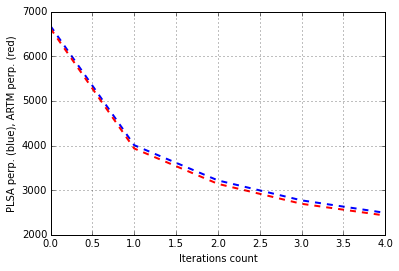

In [8]:
def print_measures(model_plsa, model_artm):
    print 'Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityPhiScore'].last_value,
        model_artm.score_tracker['SparsityPhiScore'].last_value)

    print 'Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityThetaScore'].last_value,
        model_artm.score_tracker['SparsityThetaScore'].last_value)

    print 'Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_contrast,
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast)

    print 'Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_purity,
        model_artm.score_tracker['TopicKernelScore'].last_average_purity)

    print 'Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['PerplexityScore'].last_value,
        model_artm.score_tracker['PerplexityScore'].last_value)

    plt.plot(xrange(model_plsa.num_phi_updates), model_plsa.score_tracker['PerplexityScore'].value, 'b--',
             xrange(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    
print_measures(model_plsa, model_artm)

Видно, что улучшения разреженностей и ядровых характеристик есть, а ухудшение перплексии невелико. Попробуем увеличить по модулю значения коэффициентов регуляризации при регуляризаторах:

In [9]:
model_artm.regularizers['SparsePhi'].tau = -1.2
model_artm.regularizers['SparseTheta'].tau = -0.6
model_artm.regularizers['DecorrelatorPhi'].tau = 4.5e+5

Кроме того, подключим к каждой из моделей функционал TopTokensScore, который позволит взглянуть на самые вероятные слова в каждой теме:

In [10]:
model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))

Продолжим обучение моделей, инициировав 25 проходов по коллекции, после чего снова посмотрим на значения функционалов качества:

In [11]:
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Sparsity Phi: 0.204 (PLSA) vs. 0.831 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.517 (ARTM)
Kernel contrast: 0.542 (PLSA) vs. 0.687 (ARTM)
Kernel purity: 0.422 (PLSA) vs. 0.725 (ARTM)
Perplexity: 1624.300 (PLSA) vs. 1705.470 (ARTM)


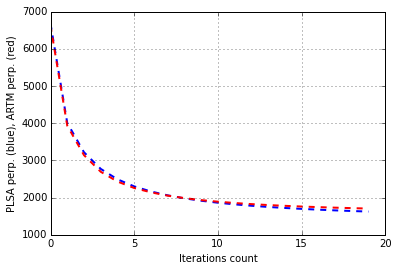

In [12]:
print_measures(model_plsa, model_artm)

Кажется, что достигнутых результатов достаточно. Регуляризация позволила добиться улучшения всех характеристик, ухудшив перплексию в пределах разумного. Взглянем на топ-слова слова моделей:

In [13]:
for topic_name in model_plsa.topic_names:
    print topic_name + ': ',
    print model_plsa.score_tracker['TopTokensScore'].last_topic_info[topic_name].tokens

@topic_0:  [u'bush', u'tax', u'states', u'rights', u'law', u'president']
@topic_1:  [u'iraq', u'war', u'military', u'iraqi', u'troops', u'soldiers']
@topic_2:  [u'november', u'poll', u'house', u'governor', u'electoral', u'account']
@topic_3:  [u'senate', u'republican', u'race', u'democrats', u'gop', u'republicans']
@topic_4:  [u'time', u'people', u'speech', u'general', u'election', u'bush']
@topic_5:  [u'dean', u'edwards', u'kerry', u'primary', u'clark', u'democratic']
@topic_6:  [u'state', u'race', u'district', u'elections', u'candidate', u'nader']
@topic_7:  [u'administration', u'bush', u'jobs', u'years', u'year', u'commission']
@topic_8:  [u'campaign', u'democratic', u'party', u'dean', u'media', u'political']
@topic_9:  [u'house', u'million', u'money', u'republican', u'republicans', u'delay']
@topic_10:  [u'november', u'voting', u'vote', u'kerry', u'republicans', u'electoral']
@topic_11:  [u'bush', u'iraq', u'war', u'administration', u'president', u'intelligence']
@topic_12:  [u'bus

In [14]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    print model_artm.score_tracker['TopTokensScore'].last_topic_info[topic_name].tokens

@topic_0:  [u'party', u'tax', u'issue', u'political', u'law', u'issues']
@topic_1:  [u'military', u'troops', u'iraqi', u'soldiers', u'forces', u'killed']
@topic_2:  [u'november', u'account', u'electoral', u'governor', u'polls', u'republicans']
@topic_3:  [u'debate', u'convention', u'carson', u'senator', u'oklahoma', u'coburn']
@topic_4:  [u'specter', u'toomey', u'hoeffel', u'server', u'workers', u'steel']
@topic_5:  [u'dean', u'edwards', u'clark', u'primary', u'iowa', u'gephardt']
@topic_6:  [u'state', u'race', u'candidate', u'candidates', u'win', u'party']
@topic_7:  [u'administration', u'jobs', u'years', u'commission', u'health', u'billion']
@topic_8:  [u'campaign', u'media', u'press', u'sunday', u'unions', u'message']
@topic_9:  [u'house', u'republican', u'gop', u'republicans', u'democrats', u'money']
@topic_10:  [u'voting', u'stolen', u'protests', u'cities', u'christopher', u'planned']
@topic_11:  [u'iraq', u'war', u'administration', u'bush', u'american', u'president']
@topic_12:  

Видно, что темы примерно одинаково интерпретируемы, но в модели ARTM они существенно разнообразнее.

Извлечём матрицу $\Phi$ в виде pandas.DataFrame и напечатаем её (в случае необходимости, можно извлекать части матрицы с помощью метода ARTM.get_phi()):

In [15]:
print model_artm.phi_

            @topic_0  @topic_1  @topic_2  @topic_3  @topic_4  @topic_5  \
aarp        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
abandon     0.000490  0.000000  0.000000  0.000000  0.000000  0.000057   
abandoned   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
abandoning  0.000000  0.000000  0.000000  0.000029  0.000000  0.000000   
abb         0.000584  0.000000  0.000000  0.000000  0.000000  0.000000   
abc         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
abcs        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
abdullah    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ability     0.000365  0.000000  0.000000  0.000000  0.000000  0.000210   
aboard      0.000000  0.000036  0.000000  0.000000  0.001096  0.000000   
abortion    0.003185  0.000000  0.000000  0.000000  0.000000  0.000000   
abortions   0.000460  0.000000  0.000000  0.000000  0.000000  0.000000   
abraham     0.000000  0.000000  0.0000

Модель можно сохранить с возможностью последующей загрузки:

In [16]:
model_artm.save(filename='kos_artm_model')  # save the model to disk

# model = artm.ARTM(...)                    # create new model
# model.load(filename='kos_artm_model')     # load saved model into new instance

Дополнительно извлечём $\Theta$ в виде pandas.DataFrame и напечатаем её:

In [17]:
theta_matrix = model_artm.fit_transform()
print theta_matrix

               2001      2002      2003      2004      2005      2006  \
@topic_0   0.059361  0.071309  0.000000  0.055310  0.000000  0.000000   
@topic_1   0.000000  0.000000  0.000000  0.130312  0.000000  0.000000   
@topic_2   0.000000  0.000000  0.000000  0.000000  0.000000  0.958567   
@topic_3   0.000000  0.009461  0.000000  0.000000  0.000000  0.000000   
@topic_4   0.000000  0.000000  0.000000  0.066487  0.000000  0.000000   
@topic_5   0.057320  0.370094  0.420234  0.063473  0.536034  0.000000   
@topic_6   0.070753  0.037187  0.083475  0.000000  0.026722  0.009322   
@topic_7   0.000000  0.000000  0.000000  0.309561  0.000000  0.000000   
@topic_8   0.046425  0.250903  0.199071  0.002631  0.000000  0.000000   
@topic_9   0.674678  0.000000  0.000000  0.000000  0.000000  0.000000   
@topic_10  0.000000  0.000000  0.000000  0.000000  0.000000  0.002501   
@topic_11  0.000000  0.000000  0.000000  0.130017  0.000000  0.000000   
@topic_12  0.091463  0.180274  0.297220  0.114989  

Можно использовать модель для определения векторов $\theta_d$ для новых документов с помощью метода ARTM.transform():

In [18]:
test_batch_vectorizer = artm.BatchVectorizer(data_format='batches', data_path='kos_test', batches=['test_docs.batch'])
test_theta_matrix = model_artm.transform(batch_vectorizer=test_batch_vectorizer)
print test_theta_matrix

                   3001          3002          3003          3004  \
@topic_0   1.763205e-01  1.668261e-02  1.308945e-01  1.696613e-01   
@topic_1   7.824659e-02  2.114283e-05  3.036711e-06  2.432359e-06   
@topic_2   5.843189e-08  4.190315e-02  2.270862e-04  9.053700e-04   
@topic_3   1.613574e-03  1.187558e-07  5.671353e-03  7.753362e-02   
@topic_4   5.899861e-02  3.702825e-02  6.633188e-03  2.012216e-10   
@topic_5   1.073009e-06  2.665936e-10  2.407749e-08  4.757242e-04   
@topic_6   1.023508e-01  1.994235e-02  2.555638e-01  2.663486e-02   
@topic_7   1.187990e-03  3.771728e-02  7.494637e-09  1.124919e-04   
@topic_8   4.613461e-04  3.142305e-05  7.882086e-04  3.989534e-02   
@topic_9   1.015007e-01  7.538985e-01  1.657844e-07  5.034531e-01   
@topic_10  1.260492e-07  0.000000e+00  3.166175e-02  2.019347e-10   
@topic_11  3.769570e-01  3.745681e-02  7.652659e-02  1.397089e-02   
@topic_12  9.156749e-02  4.729452e-02  4.895082e-01  1.490002e-01   
@topic_13  4.938944e-03  7.019292e

#### Выводы

Задача построения тематической модели имеет бесконечно большое множество решений. Это даёт большую свободу действий, и регуляризаторы позволяют использовать её для получения результата, удовлетворяющего сразу нескольким требованиям (разреженность, интерпретируемость, удовлетворительное значение перплексии и т.п.).

Приведённый выше пример является демонстрационным, можно пробовать более гибкие стратегии регуляризации для получения ещё более хорошего результата. По аналогичной схеме можно производить эксперименты с более крупными коллекциями.